In [2]:
import sys
import sql
import pandas as pd
from functools import reduce
import datetime
import matplotlib.pyplot as plt


In [3]:
q='''select *
from advisory
join package p on advisory.package_id = p.id;'''
df = pd.DataFrame(sql.execute(q))
df.id.count(), df['p.id'].nunique(), df.type.nunique(), (df['type'] == 'Malicious Package').sum()


(6956, 3935, 368, 588)

In [4]:
q='''select t1.ecosystem as ecosystem, advisories, advisory_with_CVEs, packages
from
(select ecosystem, count(distinct a.id) as advisories, count(distinct p.id) as packages
from advisory a
join package p on a.package_id = p.id
where type != 'Malicious Package'
group by ecosystem) as t1
join
(select ecosystem, count(distinct a.id) as advisory_with_CVEs
from advisoryCVE aC
join advisory a on aC.advisory_id = a.id
join package p on a.package_id = p.id
where type != 'Malicious Package'
group by ecosystem) as t2
on t1.ecosystem = t2.ecosystem
order by advisories desc;'''
df = pd.DataFrame(sql.execute(q))

In [5]:
df['non-CVEs (%)'] = df['advisories'] - df['advisory_with_CVEs']
df['non-CVEs (%)'] = round (df['non-CVEs (%)'] / df['advisories'] * 100 , 2)
df['non-CVEs (%)'].median()

23.17

In [6]:
df

,ecosystem,advisories,advisory_with_CVEs,packages,non-CVEs (%)
0,Maven,2242,1853,1275,17.35
1,npm,1210,712,910,41.16
2,Composer,928,670,261,27.80
3,pip,687,504,356,26.64
4,NuGet,405,336,135,17.04
5,cocoapods,358,358,37,0.00
6,RubyGems,278,205,166,26.26
7,Go,259,207,207,20.08


In [7]:
q='''select *
from advisory a
join package p on a.package_id = p.id
where a.type != 'Malicious Package'
and a.id not in
(select distinct advisory_id
    from advisoryCVE)'''
df = pd.DataFrame(sql.execute(q))
df['since_disclose'] = (datetime.date.today() - df['disclose_date']).dt.days
df['since_publish'] = (datetime.date.today() - df['publish_date']).dt.days
df['since_disclose'].median(), df['since_publish'].median()
p = df.groupby('ecosystem')[['since_publish']].median()
d = df.groupby('ecosystem')[['since_disclose']].median()
df = pd.merge(p,d,on='ecosystem')
df

,since_publish,since_disclose
ecosystem,,
Composer,841,1102.0
Go,295,331.5
Maven,725,850.0
NuGet,1554,1577.0
RubyGems,1417,2381.0
npm,1051,1111.0
pip,1039,1490.0


In [8]:
df['since_disclose'].median(), df['since_publish'].median()

(1111.0, 1039.0)

In [9]:
q = '''select * from
( select * from
    (select id, publish_date as snyk_publish, disclose_date, package_id
    from advisory
    where type != 'Malicious Package') as adv
    join
    (select advisory_id, min(publish_date) as cve_publish
    from advisoryCVE aC
    join CVE C on aC.cve = C.cve
    group by advisory_id) as cve
    on adv.id = cve.advisory_id
        where cve_publish > snyk_publish) as sub
join package p
    on p.id = sub.package_id;
'''
df = pd.DataFrame(sql.execute(q))
df['cve_delay'] = (df['cve_publish'].dt.date - df['snyk_publish']).dt.days
df['delay_from_disclose'] = (df['cve_publish'].dt.date - df['disclose_date']).dt.days
delay = df.groupby('ecosystem')[['cve_delay']].median()
count = df.groupby('ecosystem')[['id']].count()
disclose = df.groupby('ecosystem')[['delay_from_disclose']].median()
df=reduce(lambda x,y : pd.merge(x,y,on='ecosystem'),[count, delay, disclose])
df.columns = ['published by snyk before cve', 'median delay from snyk to cve', 'from disclose to cve']
df

,published by snyk before cve,median delay from snyk to cve,from disclose to cve
ecosystem,,,
Composer,348,8,11.0
Go,84,5,12.0
Maven,607,7,15.0
NuGet,118,1,2.0
RubyGems,106,10,11.5
cocoapods,8,0,88.5
npm,487,59,93.0
pip,264,18,22.0


In [10]:
q='''select *
from advisory a
join package p on a.package_id = p.id
where type != 'Malicious Package' and ecosystem!='cocoapods';'''
df = pd.DataFrame(sql.execute(q))
df['delay'] = (df['publish_date'] - df['disclose_date']).dt.days
df = df.groupby('ecosystem')[['delay']].median()
df

,delay
ecosystem,
Composer,0
Go,0
Maven,5
NuGet,5
RubyGems,3
npm,3
pip,0


<AxesSubplot:title={'center':'advisory count over the year'}, xlabel='publish_year'>

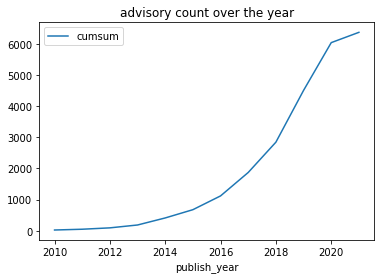

In [11]:
q='''select year(publish_date) as publish_year, count(distinct id) as count
from advisory
where type != 'Malicious Package'
group by year(publish_date);'''
df = pd.DataFrame(sql.execute(q))
df['cumsum']=df['count'].cumsum()
df.plot(x='publish_year',y='cumsum',kind='line', title = 'advisory count over the year')

<AxesSubplot:title={'center':'advisory count over the year'}, xlabel='disclose_year'>

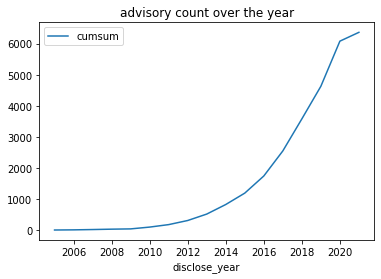

In [14]:
q='''select year(disclose_date) as disclose_year, count(distinct id) as count
from advisory
where type != 'Malicious Package'
group by year(disclose_date);'''
df = pd.DataFrame(sql.execute(q))
df['cumsum']=df['count'].cumsum()
df.plot(x='disclose_year',y='cumsum',kind='line', title = 'advisory count over the year')

In [22]:
q='''select count(*) as c from  snykvuln.advisory
where type !='Malicious Package';'''
total = sql.execute(q)[0]['c']
q='''select count(distinct a.id) as c from  snykvuln.advisory a
join fixing_releases fr on a.id = fr.advisory_id
where type !='Malicious Package';'''
fixes = sql.execute(q)[0]['c']
total, fixes, fixes/total

(6367, 4954, 0.7780744463640648)

In [26]:
q='''select a.*,p.*, year(publish_date) as publish_year
from advisory a
join package p on a.package_id=p.id
    where a.id not in
(select distinct advisory_id
from fixing_releases)
and a.type != 'Malicious Package';'''
df = pd.DataFrame(sql.execute(q))
df
df.groupby(('ecosystem'))[['id']].count()

,id
ecosystem,
Composer,58
Go,23
Maven,545
NuGet,24
RubyGems,51
cocoapods,282
npm,400
pip,30
